<a href="https://colab.research.google.com/github/YWchris/Binary-CNN-Classifier-for-Bone-age/blob/master/Copy_of_Cluster_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pecok

# Init

In [2]:
import math

import numpy as np
import matplotlib.pyplot as plt

from pecok import KMeanz

from scipy.optimize import linear_sum_assignment

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score

def build_centres(K, d, seed = 1):
    np.random.seed(seed)
    return np.random.randn(K, d) / (d ** 0.5)

def build_assignments_and_labels(K, n, seed = 1):
    np.random.seed(seed)

    ground_truth = np.random.randint(K, size = n)

    A = np.zeros([n , K])
    A[np.arange(n), ground_truth] = np.random.uniform(0, 1)

    return A, ground_truth

def build_error(n, d, sigma, seed = 1):
    np.random.seed(seed)
    return sigma * np.random.randn(n, d) / (d ** 0.5)

def build_permutation_matrix(ground_truth, est_labels):
    K = len(np.unique(ground_truth))  # Number of clusters
    n = len(est_labels)  # Number of samples

    # Create a binary matrix to represent the true assignment matrix
    A = np.zeros((n, K))
    for i, label in enumerate(ground_truth):
        A[i, label] = 1

    # Create a binary matrix to represent the estimated assignment matrix
    B = np.zeros((n, K))
    for i, label in enumerate(est_labels):
        B[i, label] = 1

    # Calculate the cost matrix as the negative dot product between the matrices A and B
    cost_matrix = -1 * np.dot(A.T, B)

    # Use the linear sum assignment algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Build the permutation matrix using the optimal assignment
    permutation_matrix = np.zeros((K, K))
    permutation_matrix[row_ind, col_ind] = 1

    return permutation_matrix

def fit_results(ground_truth, est_labels):
    # Build the permutation matrix
    permutation_matrix = build_permutation_matrix(ground_truth, est_labels)

    # One-hot encode the estimated labels
    one_hot_est_labels = np.eye(K)[est_labels]

    # Apply the permutation matrix to the estimated labels
    permuted_labels = np.argmax(
        np.dot(permutation_matrix, one_hot_est_labels.T), axis=0
    )

    # Evaluate the accuracy, precision, and recall
    accuracy = accuracy_score(ground_truth, permuted_labels)
    precision = precision_score(ground_truth, permuted_labels, average="weighted")
    recall = recall_score(ground_truth, permuted_labels, average="weighted")

    return accuracy, precision, recall

# Fit the kmeans result
def kms_result(K, X, ground_truth):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=K, n_init=10)
    est_labels = kmeans.fit_predict(X)

    return fit_results(ground_truth, est_labels)

# use GMM to do the simulation
def gmm_result(K, X, ground_truth):
    # perform gmm clustering
    gmm = GaussianMixture(n_components=K, n_init=10, max_iter = 500, tol = 0.0001)
    gmm.fit(X)
    est_labels = gmm.predict(X)

    return fit_results(ground_truth, est_labels)

def sc_result(K, X, ground_truth):
    sc = SpectralClustering(n_clusters=K, n_init=10, affinity="nearest_neighbors")
    est_labels = sc.fit_predict(X)

    return fit_results(ground_truth, est_labels)

# Test the Adapative Clustering
def kmz_result(K, X, ground_truth):
    est_labels = KMeanz(n_clusters=K, corr=2).fit(X).labels_
    return fit_results(ground_truth, est_labels)

# Simulation Code

In [3]:
def vary_sigmas(K, n, d, SIGMA):
    L = np.zeros((len(SIGMA), len(ALGS), 3))
    for i in range(len(SIGMA)):

        Z = build_centres(K, d)
        A, ground_truth = build_assignments_and_labels(K, n)
        E = build_error(n, d, SIGMA[i])

        X = A @ Z + E

        for j in range(len(ALGS)):
            np.random.seed(1)
            alg = ALGS[j]
            L[i, j, :] = alg(K, X, ground_truth)
    return L

def vary_ns(K, N, d, sigma):
    L = np.zeros((len(N), len(ALGS), 3))
    for i in range(len(N)):

        Z = build_centres(K, d)
        A, ground_truth = build_assignments_and_labels(K, N[i])
        E = build_error(N[i], d, sigma)

        X = A @ Z + E

        for j in range(len(ALGS)):
            np.random.seed(1)
            alg = ALGS[j]
            L[i, j, :] = alg(K, X, ground_truth)
    return L

def vary_ds(K, n, D, sigma):
    L = np.zeros((len(D), len(ALGS), 3))
    for i in range(len(D)):

        Z = build_centres(K, D[i])
        A, ground_truth = build_assignments_and_labels(K, n)
        E = build_error(n, D[i], sigma)

        X = A @ Z + E

        for j in range(len(ALGS)):
            np.random.seed(1)
            alg = ALGS[j]
            L[i, j, :] = alg(K, X, ground_truth)
    return L

In [4]:
ALGS = [kms_result, gmm_result, sc_result, kmz_result]
ALGS_NAMES = ['K-means', 'GMM', 'Spectural', 'K-meanz']
SCORES_NAMES = ['accuracy', 'precision', 'recall']

K = 3
d = 5
n = 500
sigma = 1.0

N = np.linspace(100, 200, num = 11).astype(int).tolist()
# N = (K + K + K * np.arange(10)).astype(int).tolist()
# N = [6,30]
S = [0.05, 0.1, 0.15, 0.25, 0.5, 1]
D = [3, 5, 7, 10, 15]
N

[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

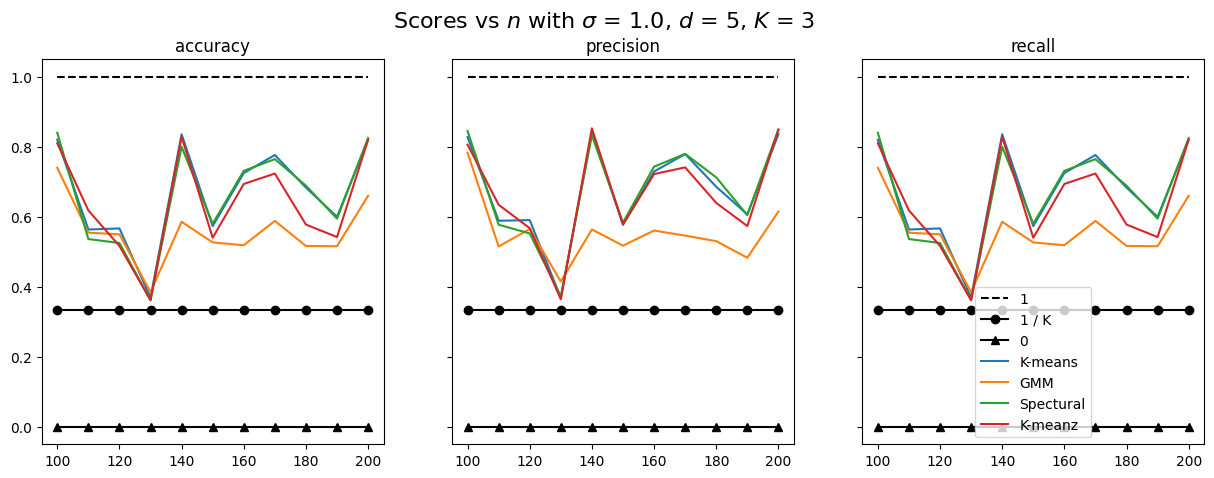

In [5]:
L_n = vary_ns(K, N, d, sigma)
fig, axs = plt.subplots(1, 3, sharey = True, sharex = True, figsize = (15, 5))

for i in range(len(SCORES_NAMES)):
    axs[i].plot(N, [1 / 1] * len(N), 'k--', label = '1')
    axs[i].plot(N, [1 / K] * len(N), 'k-o', label = '1 / K')
    axs[i].plot(N, [0 / K] * len(N), 'k^-', label = '0')
    for j in range(len(ALGS_NAMES)):
        axs[i].plot(N, L_n[:, j, i], label = ALGS_NAMES[j])
    axs[i].set_title(f'{SCORES_NAMES[i]}')

fig.suptitle(f'Scores vs $n$ with $\sigma$ = {sigma}, $d$ = {d}, $K$ = {K}', fontsize = 16)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


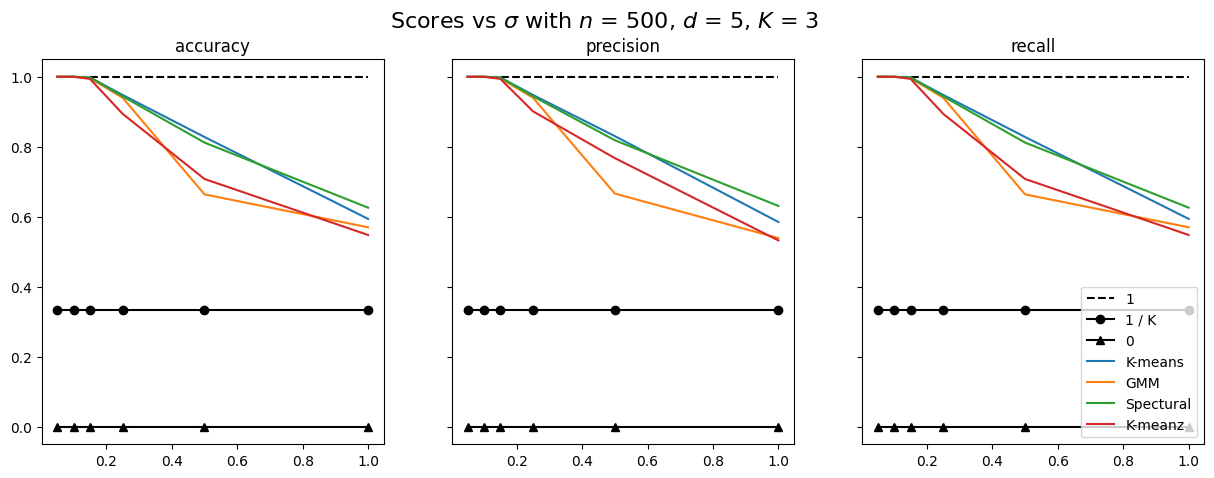

In [6]:
L_s = vary_sigmas(K, n, d, S)
fig, axs = plt.subplots(1, 3, sharey = True, sharex = True, figsize = (15, 5))

for i in range(len(SCORES_NAMES)):
    axs[i].plot(S, [1 / 1] * len(S), 'k--', label = '1')
    axs[i].plot(S, [1 / K] * len(S), 'k-o', label = '1 / K')
    axs[i].plot(S, [0 / K] * len(S), 'k^-', label = '0')
    for j in range(len(ALGS_NAMES)):
        axs[i].plot(S, L_s[:, j, i], label = ALGS_NAMES[j])
    axs[i].set_title(f'{SCORES_NAMES[i]}')

fig.suptitle(f'Scores vs $\sigma$ with $n$ = {n}, $d$ = {d}, $K$ = {K}', fontsize = 16)
plt.legend()
plt.show()

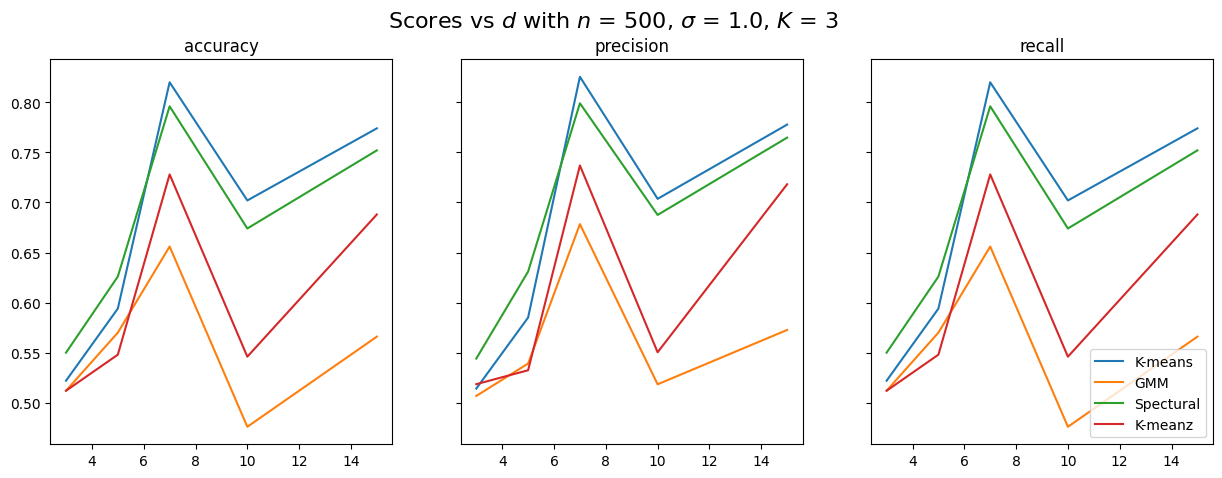

In [7]:
L_d = vary_ds(K, n, D, sigma)
fig, axs = plt.subplots(1, 3, sharey = True, sharex = True, figsize = (15, 5))

for i in range(len(SCORES_NAMES)):
    # axs[i].plot(S, [1 / 1] * len(S), 'k--', label = '1')
    # axs[i].plot(S, [1 / K] * len(S), 'k-o', label = '1 / K')
    # axs[i].plot(S, [0 / K] * len(S), 'k^-', label = '0')
    for j in range(len(ALGS_NAMES)):
        axs[i].plot(D, L_d[:, j, i], label = ALGS_NAMES[j])
    axs[i].set_title(f'{SCORES_NAMES[i]}')

fig.suptitle(f'Scores vs $d$ with $n$ = {n}, $\sigma$ = {sigma}, $K$ = {K}', fontsize = 16)
plt.legend()
plt.show()

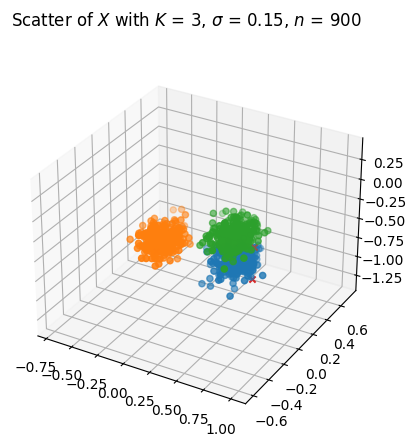

In [8]:
K = 3
d = 3
n = K * d * 100
sigma = 0.15

Z = build_centres(K, d)
A, ground_truth = build_assignments_and_labels(K, n)
E = build_error(n, d, sigma)

X = A @ Z + E

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

for k in range(K):
    I = np.argwhere(ground_truth == k).squeeze()
    ax.scatter(X[I, 0], X[I, 1], X[I, 2], label = k)

for k in range(K):
    I = np.argwhere(ground_truth == k).squeeze()
    ax.scatter(*Z[k, :], marker = 'x')

# ax.legend()
# ax.view_init(elev=20., azim=-35, roll=0)

fig.suptitle(f'Scatter of $X$ with $K$ = {K}, $\sigma$ = {sigma}, $n$ = {n}')
plt.show()

In [9]:
# K = 3
# sigma = .5

# fig, axs = plt.subplots(3, 3, sharey = all, sharex = all, figsize = (10, 10), layout='constrained')

# for m in range(len(N)):
#     np.random.seed(1)
#     i, j = divmod(m, K)
#     n = 9 + m
#     # print(i,j,n)
#     X, ground_truth = setup(K = K, n = n, d = 2, sigma = sigma)

#     axs[i, j].set_title(f'$n$ = {n}')

#     for k in range(K):
#         I = np.argwhere(ground_truth == k).squeeze()
#         axs[i, j].scatter(X[I, 0], X[I, 1])

#     Z = np.zeros((K, d))

#     for k in range(K):
#         I = np.argwhere(ground_truth == k).squeeze()
#         Z[k] = X[I, :].mean(axis = 0) # emprical centre
#         axs[i, j].scatter(*Z[k])

# fig.suptitle(f'Scatter of data, $X$ generated with $K$ = {K}, $\sigma$ = {sigma} with various $n$', fontsize = 16)
# plt.show()